# Определение перспективного тарифа для телеком компании
Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

<a id="1"></a>
## Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from functools import reduce
from scipy import stats as st

In [ ]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

<a id="2"></a>
## Шаг 2. Изучение полученных датасетов и предобработка данных

<a id="21"></a>
#### Изучение calls

In [ ]:
calls.head(10)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


In [ ]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


#### Предобработка данных calls

In [ ]:
# приведу дату в datetime64
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
#добавлю месяц для сводной
calls['month'] = calls['call_date'].dt.month 
#округление звонков в большую сторону(поминутная тарификация)
calls['duration'] = calls['duration'].apply(np.ceil)

<a id="22"></a>
#### Изучение internet

In [ ]:
internet.tail(10)

,Unnamed: 0,id,mb_used,session_date,user_id
149386,149386,1499_147,0.00,2018-10-21,1499
149387,149387,1499_148,268.19,2018-11-13,1499
149388,149388,1499_149,778.68,2018-11-24,1499
149389,149389,1499_150,273.98,2018-11-20,1499
149390,149390,1499_151,752.72,2018-10-11,1499
149391,149391,1499_152,318.90,2018-10-03,1499
149392,149392,1499_153,490.13,2018-12-14,1499
149393,149393,1499_154,0.00,2018-10-27,1499
149394,149394,1499_155,1246.32,2018-11-26,1499
149395,149395,1499_156,544.37,2018-10-26,1499


In [ ]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


#### Предобработка данных internet

In [ ]:
# приведу дату в datetime64
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
#добавлю месяц для сводной
internet['month'] = internet['session_date'].dt.month 
#не нашел элегантнее способа привести к округлению в большую сторону
internet['mb_used']=round(internet['mb_used']+0.49)
# Мб округлю до еденицы тут точно инересное соединение без единого пакета
internet.loc[internet['mb_used'] == 0, 'mb_used'] = 1

<a id="23"></a>
#### Изучение messages

In [ ]:
messages.head(10)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


In [ ]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB



#### Предобработка данных messages

In [ ]:
# приведу дату в datetime64
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
#добавлю месяц для сводной
messages['month'] = messages['message_date'].dt.month 

In [ ]:
tariffs.head(10)

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [ ]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [ ]:
users.head(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


In [ ]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


<a id="24"></a>
#### Предобработка данных users

In [ ]:
messages.head(10)
# приведу дату в datetime64
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
# Все таблицы смотрел на дубликаты и смотрел Города на регистр. Ошибок не было не стал оставлять код.

<a id="25"></a>
### Расчетны для каждого пользователя

<a id="26"></a>
#### Количество сделанных звонков и израсходованных минут разговора по месяцам;

In [ ]:
calls_in_month = calls.pivot_table(
    index=['user_id', 'month'],
    values='duration',
    aggfunc=['count', 'sum']
)
calls_in_month.columns = ['calls', 'duration']

In [ ]:
calls_in_month

calls  duration
user_id month                 
1000    5         22     164.0
        6         43     187.0
        7         47     345.0
        8         52     418.0
        9         58     477.0
...              ...       ...
1498    10        41     258.0
1499    9          9      71.0
        10        68     473.0
        11        74     624.0
        12        69     505.0

[3174 rows x 2 columns]

<a id="27"></a>
#### Количество отправленных сообщений по месяцам

In [ ]:
messages_in_month = messages.pivot_table(
    index=['user_id', 'month'],
    values='id',
    aggfunc='count'
)
messages_in_month.columns = ['num_messages']

<a id="28"></a>
#### Объем израсходованного интернет-трафика по месяцам

In [ ]:
internet_in_month = internet.pivot_table(
    index=['user_id', 'month'],
    values='mb_used',
    aggfunc='sum'
)
internet_in_month.columns = ['mb']


<a id="29"></a>
#### Помесячная выручка

In [ ]:
# Объеденим звонки минуты гигобайты каждого пользователя, и добавим тарифный план
df_users = calls_in_month.merge(messages_in_month,  on=['user_id', 'month'], how='outer')
df_users = df_users.merge(internet_in_month,  on=['user_id', 'month'], how='outer')
df_users = df_users.reset_index(drop=False)
df_users = df_users.merge(users[['user_id', 'tariff']], on='user_id', how='left')

In [ ]:
# Заменю пропущенные значения на нули
df_users.loc[df_users['duration'].isna(), 'duration'] = 0
df_users.loc[df_users['calls'].isna(), 'calls'] = 0
df_users.loc[df_users['num_messages'].isna(), 'num_messages'] = 0
df_users.loc[df_users['mb'].isna(), 'mb'] = 0
df_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 7 columns):
user_id         3214 non-null int64
month           3214 non-null int64
calls           3214 non-null float64
duration        3214 non-null float64
num_messages    3214 non-null float64
mb              3214 non-null float64
tariff          3214 non-null object
dtypes: float64(4), int64(2), object(1)
memory usage: 200.9+ KB


Вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

In [ ]:
# Пишем функции: 
def revenue_calc(row):
    duration = row['duration']
    calls = row['calls']
    num_messages = row['num_messages']
    mb = row['mb']
    tariff = row['tariff']
    
    if tariff == 'smart':
        over_duration = duration - tariffs.loc[0, 'minutes_included']
        over_mb = mb - tariffs.loc[0, 'mb_per_month_included']
        over_messages = num_messages - tariffs.loc[0, 'messages_included']
        
        if over_duration < 0:
            over_duration = 0
        if over_mb < 0:
            over_mb = 0
        if over_messages < 0:
            over_messages = 0
        
        return (tariffs.loc[0, 'rub_per_message'] * over_messages + 
                   tariffs.loc[0, 'rub_per_gb'] * ((over_mb - 1)//1024+1) + 
                   tariffs.loc[0, 'rub_per_minute'] * over_duration + 
                   tariffs.loc[0, 'rub_monthly_fee']
                  ) 
    else:
        over_duration = duration - tariffs.loc[1, 'minutes_included']
        over_mb = mb - tariffs.loc[1, 'mb_per_month_included']
        over_messages = num_messages - tariffs.loc[1, 'messages_included']
        
        if over_duration < 0:
            over_duration = 0
        if over_mb < 0:
            over_mb = 0
        if over_messages < 0:
            over_messages = 0
        
        return (tariffs.loc[1, 'rub_per_message'] * over_messages + 
                   tariffs.loc[1, 'rub_per_gb'] * ((over_mb - 1)//1024+1) + 
                   tariffs.loc[1, 'rub_per_minute'] * over_duration + 
                   tariffs.loc[1, 'rub_monthly_fee']
                  )

In [ ]:
df_users['revenue'] = df_users.apply(revenue_calc, axis=1)
df_users

,user_id,month,calls,duration,num_messages,mb,tariff,revenue
0,1000,5,22.0,164.0,22.0,2257.0,ultra,1950.0
1,1000,6,43.0,187.0,60.0,23262.0,ultra,1950.0
2,1000,7,47.0,345.0,75.0,14017.0,ultra,1950.0
3,1000,8,52.0,418.0,81.0,14072.0,ultra,1950.0
4,1000,9,58.0,477.0,57.0,14583.0,ultra,1950.0
...,...,...,...,...,...,...,...,...
3209,1489,9,0.0,0.0,32.0,17246.0,smart,950.0
3210,1489,10,0.0,0.0,21.0,19598.0,smart,1550.0
3211,1489,11,0.0,0.0,20.0,17525.0,smart,1150.0
3212,1489,12,0.0,0.0,35.0,17349.0,smart,950.0


<a id="3"></a>
## Шаг 3. Проанализируйте данные

#### Посчитаем сколько минут разговора, сообщений и объем интернет трафика требуется каждому пользователю тарифа в месяц

In [ ]:
average_demand = df_users.pivot_table(index='user_id', values=['duration', 'num_messages', 'mb', 'revenue', 'tariff'], aggfunc='median')

In [ ]:
average_demand = average_demand.merge(users[['user_id', 'tariff',]], on='user_id', how='left')
average_demand

,user_id,duration,mb,num_messages,revenue,tariff
0,1000,344.5,14327.5,65.0,1950.0,ultra
1,1001,437.0,16259.5,0.0,950.0,smart
2,1002,221.0,17614.0,11.0,1150.0,smart
3,1003,844.0,11369.0,83.0,1950.0,ultra
4,1004,136.5,17831.0,154.5,1950.0,ultra
...,...,...,...,...,...,...
493,1495,969.0,29399.0,82.0,1950.0,ultra
494,1496,544.0,24077.0,41.5,2566.0,smart
495,1497,505.0,14180.0,17.0,565.0,smart
496,1498,336.0,21400.0,43.0,1850.0,smart


<a id="31"></a>
####  Среднее колличество по тарифам

In [ ]:
tariff_consumption = average_demand.pivot_table(index='tariff', values=['duration', 'mb', 'num_messages', 'revenue'])
tariff_consumption['rub_monthly_fee'] = [550, 1950]
tariff_consumption = tariff_consumption.reset_index(drop=False)
tariff_consumption


,tariff,duration,mb,num_messages,revenue,rub_monthly_fee
0,smart,449.665714,16862.078571,33.770000,1329.301429,550
1,ultra,572.510135,20324.226351,56.983108,2061.993243,1950


<div class="alert alert-block alert-success">
<b>Комментарий ревьюера</b>

Классная таблица. Также можно округлить ее значения.

</div>


<a id="32"></a>
#### Выводы
Пользователи тарифа Ультра потребляют больше услуг и платят больше. Пользователям тарифа смарт не хватает выделенного объема услуг, им приходится больше докупать.

In [ ]:
desc_stat = average_demand.pivot_table(index=['tariff'], values=['duration', 'mb', 'num_messages'], 
                    aggfunc=[np.median, np.var, np.std])
desc_stat

median                                  var                \
       duration        mb num_messages      duration            mb   
tariff                                                               
smart    453.00  16955.00         28.5  27070.144380  1.748434e+07   
ultra    550.25  19751.75         47.5  96918.253298  7.924393e+07   

                            std                            
       num_messages    duration           mb num_messages  
tariff                                                     
smart    784.596662  164.530071  4181.428070    28.010653  
ultra   2424.263318  311.316966  8901.905696    49.236809

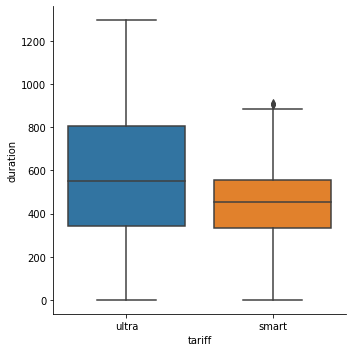

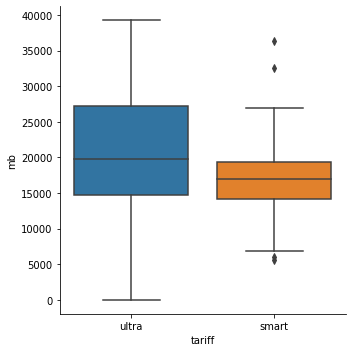

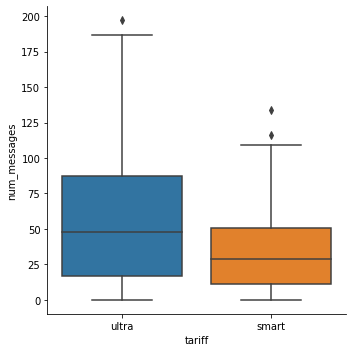

In [ ]:
import seaborn as sns
for column in ['duration', 'mb', 'num_messages']:    
    sns.catplot(x='tariff', y=column, kind="box", data=average_demand, orient='v')

In [ ]:
average_demand

,user_id,duration,mb,num_messages,revenue,tariff
0,1000,344.5,14327.5,65.0,1950.0,ultra
1,1001,437.0,16259.5,0.0,950.0,smart
2,1002,221.0,17614.0,11.0,1150.0,smart
3,1003,844.0,11369.0,83.0,1950.0,ultra
4,1004,136.5,17831.0,154.5,1950.0,ultra
...,...,...,...,...,...,...
493,1495,969.0,29399.0,82.0,1950.0,ultra
494,1496,544.0,24077.0,41.5,2566.0,smart
495,1497,505.0,14180.0,17.0,565.0,smart
496,1498,336.0,21400.0,43.0,1850.0,smart


#### Вывод
Дисперсию тарифов Ультра бошльше, и медианы смещены в большую сторону. Эти тарифы выгодее для оператора)

Text(0.5, 1.0, 'Гистограмма звонков')

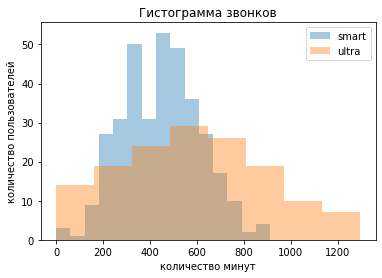

In [ ]:
smart = average_demand.query("tariff == 'smart'")
ultra = average_demand.query("tariff == 'ultra'")
sns.distplot(smart['duration'], kde=False)
sns.distplot(ultra['duration'], kde=False)
plt.legend(['smart', 'ultra'])
plt.xlabel('количество минут')
plt.ylabel('количество пользователей')
plt.title('Гистограмма звонков')

In [ ]:
smart

,user_id,duration,mb,num_messages,revenue,tariff
1,1001,437.0,16259.5,0.0,950.0,smart
2,1002,221.0,17614.0,11.0,1150.0,smart
5,1005,609.5,7846.5,49.0,884.5,smart
6,1006,364.0,15554.0,0.0,750.0,smart
7,1007,489.0,14451.0,26.0,1017.0,smart
...,...,...,...,...,...,...
492,1494,426.0,17649.0,0.0,1150.0,smart
494,1496,544.0,24077.0,41.5,2566.0,smart
495,1497,505.0,14180.0,17.0,565.0,smart
496,1498,336.0,21400.0,43.0,1850.0,smart


Text(0.5, 1.0, 'Гистограмма интернет траффика')

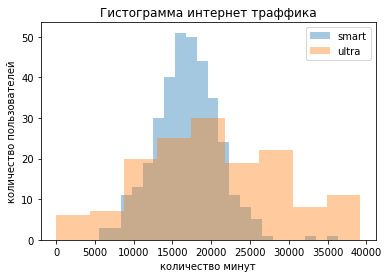

In [ ]:
smart = average_demand.query("tariff == 'smart'")
ultra = average_demand.query("tariff == 'ultra'")
sns.distplot(smart['mb'], kde=False)
sns.distplot(ultra['mb'], kde=False)
plt.legend(['smart', 'ultra'])
plt.xlabel('количество минут')
plt.ylabel('количество пользователей')
plt.title('Гистограмма интернет траффика')

<div class="alert alert-block alert-warning">
<b>Комментарий ревьюера</b>

Только не минут, а мегабайт :)

</div>


Text(0.5, 1.0, 'Гистограмма сообщений')

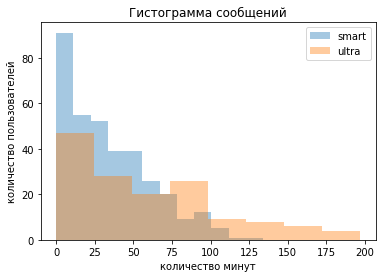

In [ ]:
smart = average_demand.query("tariff == 'smart'")
ultra = average_demand.query("tariff == 'ultra'")
sns.distplot(smart['num_messages'], kde=False)
sns.distplot(ultra['num_messages'], kde=False)
plt.legend(['smart', 'ultra'])
plt.xlabel('количество минут')
plt.ylabel('количество пользователей')
plt.title('Гистограмма сообщений')

#### Вывод
Отображенные гистаграммы показывают, что дисперсия по "Ультра"  больше, чем у пользователей с тарифом "Смарт". 
Пользователи тарифа Смарт явно себя ограничивают

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера</b>

Графики верные, показатели найдены нужные.

</div>


<a id="4"></a>
## Шаг 4. Проверка гипотез

<a id="41"></a>
#### Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различается
Формируем гимотезы:
    
H0  — Средняя выручка пользователей тарифов "Ультра" и "Смарт" равна

H1  — Средняя выручка пользователей тарифов "Ультра" и "Смарт" различается

Критический уровень статистической значимости 5%, можно брать и меньше, но есть риск отбросить работающую гипотезу.


In [ ]:
alpha = 0.05 
results = st.ttest_ind(
    smart['revenue'], 
    ultra['revenue'])

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 4.346578379453916e-28
Отвергаем нулевую гипотезу


#### Вывод
Вероятность очень близкая к нулю говорит нам что H0 гипотеза не подтвердилась, средняя выручка пользователей тарифов «Ультра» и «Смарт» дейтсвительно различаются

<a id="42"></a>
#### Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов
H0  — средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов.

H1  — средняя выручка пользователей из Москвы отличается от средней выручке пользователей из других регионов.

Критический уровень статистической значимости 5%

In [ ]:
average_demand = average_demand.merge(users[['user_id', 'city',]], on='user_id', how='left')


In [ ]:
moscow = average_demand.query('city == "Москва"')['revenue']
regions = average_demand.query('city != "Москва"')['revenue']


In [ ]:
alpha = 0.05 
results = st.ttest_ind(moscow, regions)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.3195022604418513
Не получилось отвергнуть нулевую гипотезу


Вероятность составляет 32% - не получилось отвергнуть нулевую гипотезу. Это значит, что средняя выручка из Москвы не отличается от выручки из других регионов.

In [ ]:
users['tariff'].value_counts() #посчитаем колличество пользователей каждого тарифа


smart    351
ultra    149
Name: tariff, dtype: int64

<a id="5"></a>
## Общий вывод

1. По результатам статистического анализа для оператора доходы от тарифа «Ультра»(2062р.) больше, чем от тарифа «Смарт»(1329р.)
2. Судя по гистограммам не все пользователи тарифа «Ультра» выробатывают весь доступный лимит.
3. Колличество пользователей таррифа «Смарт» больше в 2 раза, что можно объяснить более выгодными условиями
4. Доплат по тарифу «Ультра» очень мало. В тарифе «Смарт» часто доплачивают за дополнительные пакеты гигобайт
5. Средние доходы от пользователей в Москве не отличаются от доходов в других населенных пунктах

Отвечая на вопрос какой тариф лучше для оператора, это тариф Ультра.